In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from train_gan import Generator
from train_encoder import SimCLR

import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST

from utils import *

DEVICE=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED=42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]
    def __setattr__(self, attr, value):
        self[attr] = value

In [3]:
from pathlib import Path
dir_models = Path('models/')
dir_models.mkdir(exist_ok=True)

dir_logs = Path('logs')
dir_logs.mkdir(exist_ok=True)

In [4]:
# !wget https://github.com/csinva/gan-vae-pretrained-pytorch/raw/master/mnist_dcgan/weights/netG_epoch_99.pth  -O models/mnist_gan.pth -q

In [5]:
z_dim=100
y_dim=512

In [6]:
G = Generator().to(DEVICE)
G.load_state_dict(torch.load("models/mnist_gan.pth"))
# E.load_state_dict(torch.load("models/encoder_mnist.pth"))
                  
for p in G.parameters():
    p.requires_grad = False

In [7]:
holdout_mnist = MNIST(root="data", train=False, download=True, transform=T.Compose([
    T.Resize(28),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
]))

# evaluation samples are used to check that enc(img) -> y -> m(y) -> G(m(y)) is a valid inversion
eval_samples = torch.stack([holdout_mnist[idx][0] for idx in random.sample(range(len(holdout_mnist)), k=5)]).to(DEVICE)

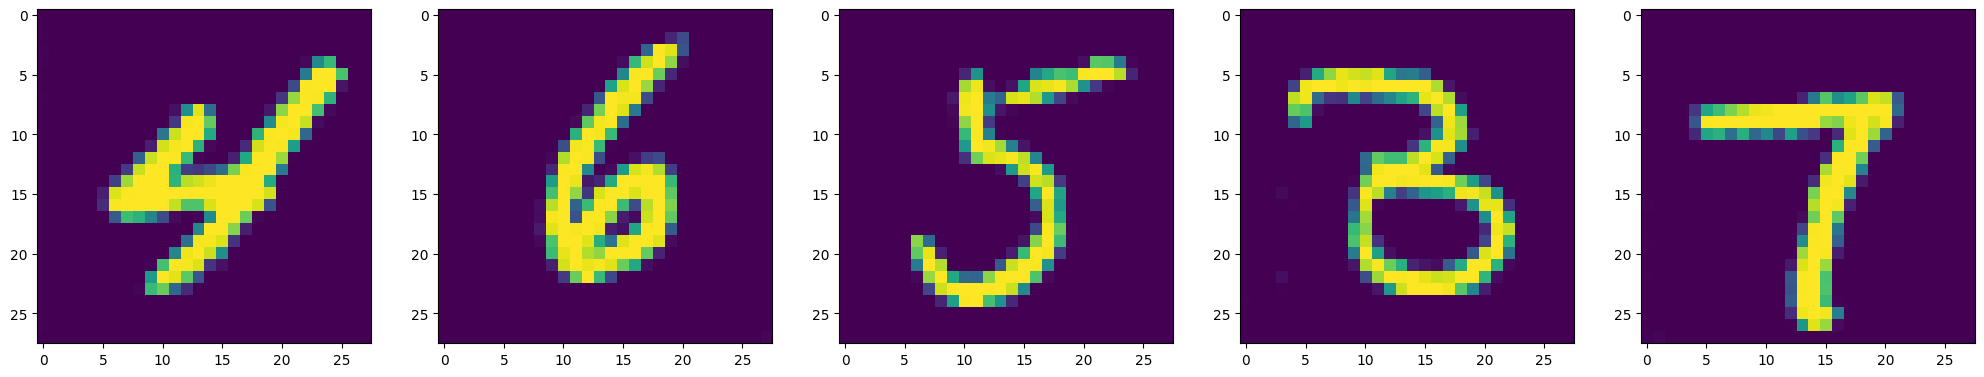

In [8]:
# gan quality sanity check
z = torch.randn((5, z_dim), device=DEVICE)
with torch.no_grad():
    images = G(z[:,:, None, None])

images = images.detach().cpu().numpy()
_, axs = plt.subplots(1, 5, figsize=(25, 10))
for (ax, img) in zip(axs, images):
    ax.imshow(img.reshape((28, 28)))

# SAE

In [9]:
# Copied from https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/sparsifiers.py

class SAE(nn.Module):
    """
    Sparse AutoEncoder
    """

    def __init__(
        self, 
        input_size: int, 
        n_dict_components: int, 
        init_decoder_orthogonal: bool = True
    ):
        """Initialize the SAE.

        Args:
            input_size: Dimensionality of input data
            n_dict_components: Number of dictionary components
            init_decoder_orthogonal: Initialize the decoder weights to be orthonormal
        """

        super().__init__()
        # self.encoder[0].weight has shape: (n_dict_components, input_size)
        # self.decoder.weight has shape:    (input_size, n_dict_components)

        self.encoder = nn.Sequential(nn.Linear(input_size, n_dict_components, bias=True), nn.ReLU())
        self.decoder = nn.Linear(n_dict_components, input_size, bias=True)
        self.n_dict_components = n_dict_components
        self.input_size = input_size

        if init_decoder_orthogonal:
            # Initialize so that there are n_dict_components orthonormal vectors
            self.decoder.weight.data = nn.init.orthogonal_(self.decoder.weight.data.T).T

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Pass input through the encoder and normalized decoder."""
        latents = self.encoder(x)
        x_hat = F.linear(latents, self.dict_elements, bias=self.decoder.bias)
        return x_hat, latents
    
    def encode(self, x):
        latents = self.encoder(x)
        return latents
    
    def decode(self, latents):
        x_hat = F.linear(latents, self.dict_elements, bias=self.decoder.bias)
        return x_hat, latents

    @property
    def dict_elements(self):
        """Dictionary elements are simply the normalized decoder weights."""
        return F.normalize(self.decoder.weight, dim=0)

    @property
    def device(self):
        return next(self.parameters()).device

In [10]:
# https://github.com/openai/sparse_autoencoder/blob/main/sparse_autoencoder/loss.py

def autoencoder_loss(
    reconstruction: torch.Tensor,
    original_input: torch.Tensor,
    latent_activations: torch.Tensor,
    l1_weight: float,
) -> torch.Tensor:
    """
    :param reconstruction: output of Autoencoder.decode (shape: [batch, n_inputs])
    :param original_input: input of Autoencoder.encode (shape: [batch, n_inputs])
    :param latent_activations: output of Autoencoder.encode (shape: [batch, n_latents])
    :param l1_weight: weight of L1 loss
    :return: loss (shape: [1])
    """
    return (
        normalized_mean_squared_error(reconstruction, original_input)
        + normalized_L1_loss(latent_activations, original_input) * l1_weight
    )

def normalized_mean_squared_error(
    reconstruction: torch.Tensor,
    original_input: torch.Tensor,
) -> torch.Tensor:
    """
    :param reconstruction: output of Autoencoder.decode (shape: [batch, n_inputs])
    :param original_input: input of Autoencoder.encode (shape: [batch, n_inputs])
    :return: normalized mean squared error (shape: [1])
    """
    return (
        ((reconstruction - original_input) ** 2).mean(dim=1) / (original_input**2).mean(dim=1)
    ).mean()

def normalized_L1_loss(
    latent_activations: torch.Tensor,
    original_input: torch.Tensor,
) -> torch.Tensor:
    """
    :param latent_activations: output of Autoencoder.encode (shape: [batch, n_latents])
    :param original_input: input of Autoencoder.encode (shape: [batch, n_inputs])
    :return: normalized L1 loss (shape: [1])
    """
    return (latent_activations.abs().sum(dim=1) / original_input.norm(dim=1)).mean()

# Play with SAE and GAN output

In [11]:
# generate noise
n_images = 8
z = torch.randn((n_images, z_dim), device=DEVICE)

# generated noise 
z.shape

torch.Size([8, 100])

In [12]:
# generated images from noise `z`
images.shape

(5, 1, 28, 28)

In [13]:
# the GAN itself
G

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [14]:
# embedding size - input size for SAE
emb_size = z.shape[-1]

# SAE init
sae_z = SAE(
    input_size=emb_size,
    n_dict_components=emb_size*5,
)
sae_z.to(DEVICE);

In [15]:
sae_z

SAE(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU()
  )
  (decoder): Linear(in_features=500, out_features=100, bias=True)
)

In [16]:
# function for image generation from noise 
@torch.no_grad()
def z_to_img(model_gan, noise_embs, bs_one=True):
    original_device = noise_embs.device

    if bs_one:
        # the mo`del has the batchnorm, so process noise independently 
        # for images not to affect each other
        images = list()
        for noise_emb_ in noise_embs:
            image_ = model_gan(noise_emb_[None, :, None, None].to(DEVICE))
            images.append(image_)
        images = torch.cat(images)
    else:
        images = model_gan(noise_embs[:,:, None, None].to(DEVICE))

    images = images.to(original_device)
    return images

# function to plot 5 images in a row for all in input array
def plot_numpy_imgs5row(imgs_array, figsize=(10,4)):
    nrows = int(np.ceil(imgs_array.__len__()/5))
    _, axs = plt.subplots(nrows, 5, figsize=figsize)
    axs = axs.flatten()
    for (ax, img) in zip(axs, imgs_array):
        ax.imshow(img.reshape((28, 28)))
    plt.show()

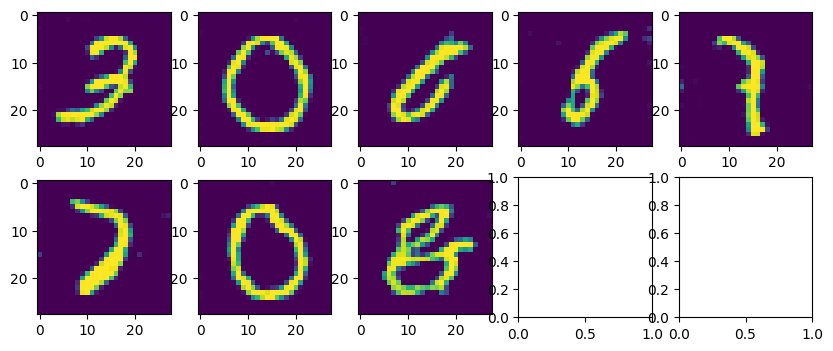

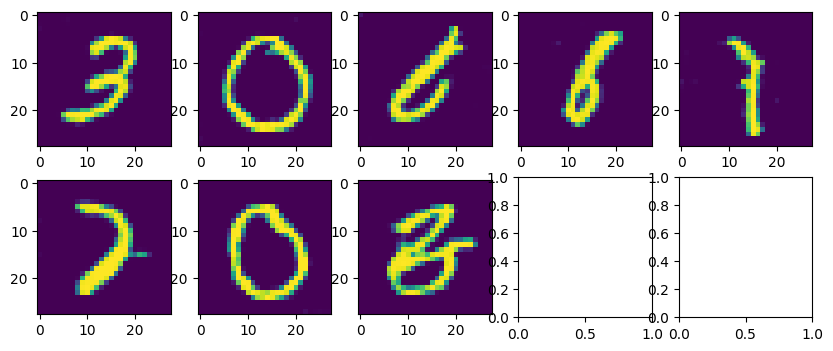

In [17]:
# generation wo batches
images1 = z_to_img(G, z, bs_one=True)
plot_numpy_imgs5row(images1.detach().cpu().numpy())

# same noise with batched generation
images1 = z_to_img(G, z, bs_one=False)
plot_numpy_imgs5row(images1.detach().cpu().numpy())

# the difference is visible but small

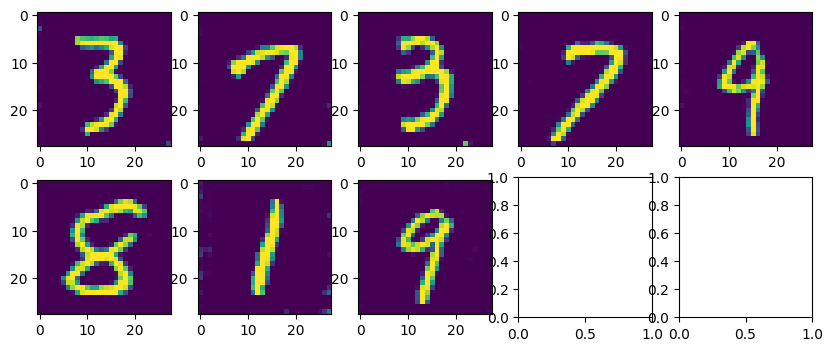

In [18]:
# z_re, latents = sae_z(z)

# Get latents, activations in the bottleneck
latents = sae_z.encode(z)

# steer generation, change latent
# the extreme values like 100 break other images if the Generator has the batchnorm working
# latents[4, 42] = 100

# decode from latents
z_re, latents = sae_z.decode(latents=latents)

# generate images from the reconstructed z - `z_re`
images_re = z_to_img(G, z_re)
# plot images from `z_re`
plot_numpy_imgs5row(images_re.detach().cpu().numpy())

# Train SAE

In [19]:
BS = 32
L1_SCALE = 0.01
N_EPOCHS = 20

In [20]:
n_train_samples = 10_000
z_train = torch.randn((n_train_samples, z_dim), device='cpu')
x_train = z_to_img(G, z_train)

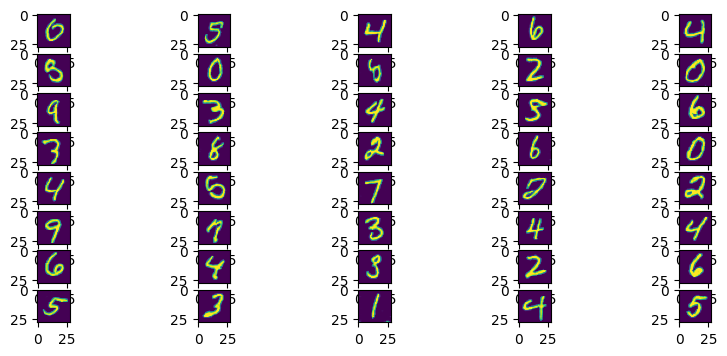

In [21]:
plot_numpy_imgs5row(x_train[:40].cpu().numpy())

In [22]:
class CustomDatasetMNISTgen(torch.utils.data.Dataset):
    def __init__(self, z_array, x_array):
        self.z_array = z_array
        self.x_array = x_array

    def __len__(self):
        return len(self.z_array)

    def __getitem__(self, idx):
        z_out, x_out = self.z_array[idx], self.x_array[idx]
        return (z_out, x_out)

In [23]:
dataset = CustomDatasetMNISTgen(z_array=z_train, x_array=x_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS,
                                         shuffle=False, num_workers=0)

99| Loss L1: 1.760e-02, MSE(X): 7.05544e-04, MSE(z): 4.740e-03


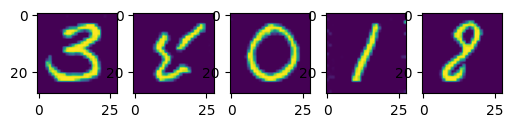

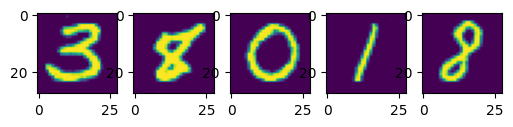

100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


In [24]:
from IPython.display import display, clear_output

N_EPOCHS = 100
L1_SCALE = 1e-3
REC_X_SCALE = 1e-8
REC_Z_SCALE = 1e-0
BS = 32
# ------------
# embedding size - input size for SAE
emb_size = z.shape[-1]
# SAE init
sae_z = SAE(input_size=emb_size,n_dict_components=emb_size*2)
sae_z.to(DEVICE);

G = Generator().to(DEVICE)
G.load_state_dict(torch.load("models/mnist_gan.pth"))

G.eval()
sae_z.train()
for n, p in G.named_parameters():
    p.requires_grad_(False)
for n, p in sae_z.named_parameters():
    p.requires_grad_(True)

optimizer = torch.optim.Adam(sae_z.parameters(), lr=1e-4)

dataset = CustomDatasetMNISTgen(z_array=z_train, x_array=x_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS,
                                         shuffle=False, num_workers=0)

for epoch in tqdm(range(N_EPOCHS), leave=True):
    l1_loss_running = 0
    mse_loss_x_running = 0
    mse_loss_z_running = 0
    for batch in tqdm(dataloader, leave=False):
        z_batch, x_batch = batch
        z_batch, x_batch = z_batch.to(DEVICE), x_batch.to(DEVICE)

        optimizer.zero_grad()
        
        z_re, latents = sae_z(z_batch.to(sae_z.device))
        # x_re = z_to_img(G, z_re) # no grads
        x_re = G(z_re[:,:, None, None].to(DEVICE))

        l1_loss = L1_SCALE*normalized_L1_loss(latent_activations=latents, original_input=z_batch)
        mse_loss_x = REC_X_SCALE*normalized_mean_squared_error(reconstruction=x_re, original_input=x_batch)
        mse_loss_z = REC_Z_SCALE*normalized_mean_squared_error(reconstruction=z_re, original_input=z_batch)
        loss = l1_loss + mse_loss_z + mse_loss_x
        
        loss.backward()
        optimizer.step()

        # TODO: Count L0, num_alive stats on latents

        l1_loss_running += l1_loss.item() / len(dataloader)
        mse_loss_x_running += mse_loss_x.item() / len(dataloader)
        mse_loss_z_running += mse_loss_z.item() / len(dataloader)

    clear_output()

    x_sample = z_to_img(G, z_re[:5])
    loss_str = f"{epoch:02d}| Loss L1: {l1_loss_running:.3e}, MSE(X): {mse_loss_x_running:.5e}, MSE(z): {mse_loss_z_running:.3e}"
    print(loss_str)
    plot_numpy_imgs5row(x_batch[:5].cpu().numpy(), figsize=(6,3))
    plot_numpy_imgs5row(x_sample.cpu().numpy(), figsize=(6,3))

# Play trained SAE

In [25]:
(latents > 0).sum(-1)

tensor([193, 193, 191, 191, 193, 194, 191, 195, 190, 185, 192, 194, 189, 188,
        190, 190], device='cuda:0')

In [26]:
latents.sort()

torch.return_types.sort(
values=tensor([[0.0000, 0.0000, 0.0000,  ..., 2.2246, 2.2494, 2.5496],
        [0.0000, 0.0000, 0.0000,  ..., 2.1111, 2.4188, 2.7595],
        [0.0000, 0.0000, 0.0000,  ..., 2.1342, 2.2761, 2.4039],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.8847, 2.1288, 2.2267],
        [0.0000, 0.0000, 0.0000,  ..., 1.9252, 1.9465, 2.2181],
        [0.0000, 0.0000, 0.0000,  ..., 2.1981, 2.5148, 2.8338]],
       device='cuda:0', grad_fn=<SortBackward0>),
indices=tensor([[ 28,  37,  72,  ..., 118, 177,  20],
        [ 10,  36,  42,  ...,  52, 164,  86],
        [  5,  61,  91,  ...,   9,  78, 185],
        ...,
        [ 28,  53,  71,  ..., 172,  99,  60],
        [ 10,  14,  19,  ..., 137, 121, 106],
        [ 10,  24,  32,  ...,  31, 190, 184]], device='cuda:0'))

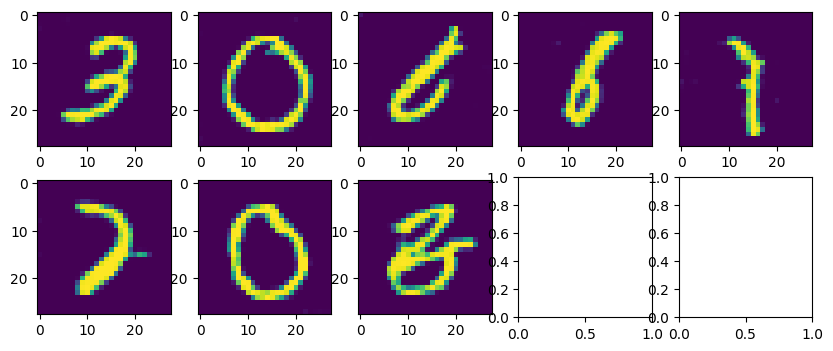

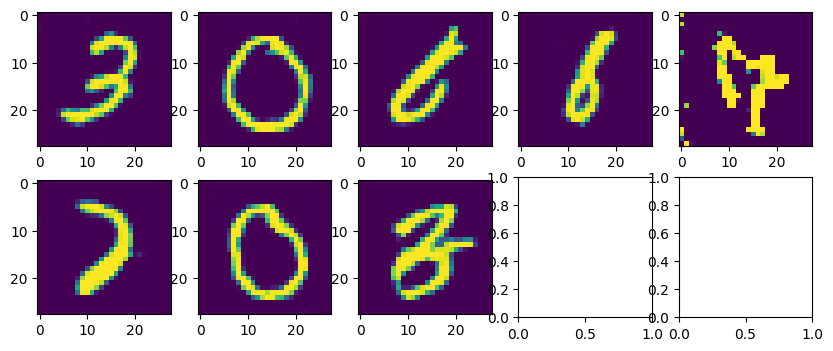

In [39]:
sae_z.eval()
with torch.no_grad():
    plot_numpy_imgs5row(images1.detach().cpu().numpy())

    # z_re, latents = sae_z(z)

    # Get latents, activations in the bottleneck
    latents = sae_z.encode(z)

    # steer generation, change latent
    # the extreme values like 100 break other images if the Generator has the batchnorm working
    # latents[4, 252] = 42 # digit 4
    # latents[4, 15] = 40 # number 7
    latents[4, 2] = 40 # number 2

    # decode from latents
    z_re, latents = sae_z.decode(latents=latents)

    # generate images from the reconstructed z - `z_re`
    images_re = z_to_img(G, z_re)
    # plot images from `z_re`
    plot_numpy_imgs5row(images_re.detach().cpu().numpy())